# PRODIGY InfoTech Task-5-2
Analyze traffic accident data to identify patterns related to road conditions, weather, and time of day. Visualize accident hotspots and contributing factors.

Dataset :- https://www.kaggle.com/code/harshalbhamare/us-accident-eda

In [1]:
pip install category_encoders --user


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

In [4]:
data = pd.read_csv('sample.csv')
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1154700,Source3,2,2021-02-12 08:22:52,2021-02-12 10:34:23,40.726833,-73.375107,NaN,NaN,0.000,One lane blocked due to accident on Southern P...,Southern State Pkwy W,West Babylon,Suffolk,NY,11704,US,US/Eastern,KFRG,2021-02-12 07:53:00,20.0,9.0,40.0,30.26,10.0,N,10.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-7326903,Source1,2,2019-10-03 07:42:00,2019-10-03 08:53:59,35.446737,-120.638870,35.446737,-120.638870,0.000,At Santa Barbara Rd/Exit 216A - Accident.,El Camino Real S,Atascadero,San Luis Obispo,CA,93422,US,US/Pacific,KPRB,2019-10-03 07:53:00,42.0,42.0,67.0,29.12,NaN,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-2424082,Source2,2,2018-11-01 20:48:46,2018-11-01 21:18:25,39.983772,-76.734970,NaN,NaN,0.000,Accident on US-30 Arsenal Rd at I-83 Bus Georg...,N George St,York,York,PA,17404-1806,US,US/Eastern,KTHV,2018-11-01 20:53:00,66.0,NaN,70.0,29.74,10.0,South,9.2,0.0,Light Rain,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night
3,A-305665,Source2,3,2016-07-25 07:17:34,2016-07-25 08:06:51,29.797060,-95.271584,NaN,NaN,0.000,Two lanes blocked and right hand shoulder bloc...,N McCarty St,Houston,Harris,TX,77029,US,US/Central,KHOU,2016-07-25 06:53:00,82.0,NaN,82.0,29.96,10.0,NW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
4,A-6189814,Source1,2,2021-03-12 05:54:00.000000000,2021-03-12 16:54:21.000000000,34.277612,-118.608624,34.277312,-118.604924,0.212,Stationary traffic at exit [34] due to accident.,CA-118,Chatsworth,Los Angeles,CA,91311,US,US/Pacific,KVNY,2021-03-12 05:51:00,40.0,40.0,83.0,29.23,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day


## Data Exploration :

In [5]:
#Checking the dimension of the training dataset:
print("The total rows in the dataset is:" ,data.shape[0] ,"\nThe total columns in the dataset is:" ,data.shape[1])

The total rows in the dataset is: 100000 
The total columns in the dataset is: 46


In [6]:
#Converting into date time format:
data['Start_Time'] = pd.to_datetime(data["Start_Time"], errors="coerce")
data['End_Time'] = pd.to_datetime(data["End_Time"], errors="coerce")
data["Year"]=data["Start_Time"].dt.year
data["Severity"]=data["Severity"].apply(lambda x : str(x))
data["Hour"]=data["Start_Time"].dt.hour
data["Month"]=data["Start_Time"].dt.month
data["Day"]=data["Start_Time"].dt.day_name()
data['Time_of_Year'] = data['Start_Time'].dt.quarter
data['Duration'] = data['End_Time'] - data['Start_Time']
data['Duration_in_minutes'] = data['Duration'].dt.total_seconds() / 60
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Hour,Month,Day,Time_of_Year,Duration,Duration_in_minutes
0,A-1154700,Source3,2,2021-02-12 08:22:52,2021-02-12 10:34:23,40.726833,-73.375107,NaN,NaN,0.000,One lane blocked due to accident on Southern P...,Southern State Pkwy W,West Babylon,Suffolk,NY,11704,US,US/Eastern,KFRG,2021-02-12 07:53:00,20.0,9.0,40.0,30.26,10.0,N,10.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2021,8,2,Friday,1,0 days 02:11:31,131.516667
1,A-7326903,Source1,2,2019-10-03 07:42:00,2019-10-03 08:53:59,35.446737,-120.638870,35.446737,-120.638870,0.000,At Santa Barbara Rd/Exit 216A - Accident.,El Camino Real S,Atascadero,San Luis Obispo,CA,93422,US,US/Pacific,KPRB,2019-10-03 07:53:00,42.0,42.0,67.0,29.12,NaN,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2019,7,10,Thursday,4,0 days 01:11:59,71.983333
2,A-2424082,Source2,2,2018-11-01 20:48:46,2018-11-01 21:18:25,39.983772,-76.734970,NaN,NaN,0.000,Accident on US-30 Arsenal Rd at I-83 Bus Georg...,N George St,York,York,PA,17404-1806,US,US/Eastern,KTHV,2018-11-01 20:53:00,66.0,NaN,70.0,29.74,10.0,South,9.2,0.0,Light Rain,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,2018,20,11,Thursday,4,0 days 00:29:39,29.650000
3,A-305665,Source2,3,2016-07-25 07:17:34,2016-07-25 08:06:51,29.797060,-95.271584,NaN,NaN,0.000,Two lanes blocked and right hand shoulder bloc...,N McCarty St,Houston,Harris,TX,77029,US,US/Central,KHOU,2016-07-25 06:53:00,82.0,NaN,82.0,29.96,10.0,NW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,2016,7,7,Monday,3,0 days 00:49:17,49.283333
4,A-6189814,Source1,2,2021-03-12 05:54:00,2021-03-12 16:54:21,34.277612,-118.608624,34.277312,-118.604924,0.212,Stationary traffic at exit [34] due to accident.,CA-118,Chatsworth,Los Angeles,CA,91311,US,US/Pacific,KVNY,2021-03-12 05:51:00,40.0,40.0,83.0,29.23,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,2021,5,3,Friday,1,0 days 11:00:21,660.350000


In [7]:
# Checking the type of data in each column:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 53 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   ID                     100000 non-null  object         
 1   Source                 100000 non-null  object         
 2   Severity               100000 non-null  object         
 3   Start_Time             100000 non-null  datetime64[ns] 
 4   End_Time               100000 non-null  datetime64[ns] 
 5   Start_Lat              100000 non-null  float64        
 6   Start_Lng              100000 non-null  float64        
 7   End_Lat                55805 non-null   float64        
 8   End_Lng                55805 non-null   float64        
 9   Distance(mi)           100000 non-null  float64        
 10  Description            100000 non-null  object         
 11  Street                 99849 non-null   object         
 12  City                   99998 no

In [8]:
# Calculating the number of categorical and numeric column:
data.dtypes.value_counts()

object             20
float64            13
bool               13
int64               4
datetime64[ns]      2
timedelta64[ns]     1
dtype: int64

In [9]:
#checking for missing values
data.isna().sum().sort_values(ascending = False)

End_Lng                  44195
End_Lat                  44195
Precipitation(in)        28694
Wind_Chill(F)            26026
Wind_Speed(mph)           7390
Wind_Direction            2318
Visibility(mi)            2301
Weather_Condition         2254
Humidity(%)               2246
Temperature(F)            2109
Pressure(in)              1829
Weather_Timestamp         1591
Airport_Code               337
Astronomical_Twilight      318
Nautical_Twilight          318
Civil_Twilight             318
Sunrise_Sunset             318
Street                     151
Timezone                   116
Zipcode                     31
City                         2
Railway                      0
Year                         0
Hour                         0
Month                        0
Day                          0
Turning_Loop                 0
Time_of_Year                 0
Duration                     0
Traffic_Signal               0
Traffic_Calming              0
Stop                         0
Station 

In [10]:
#Descriptive Analysis 
data.describe()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Year,Hour,Month,Time_of_Year,Duration,Duration_in_minutes
count,100000.000000,100000.000000,55805.000000,55805.000000,100000.000000,97891.000000,73974.000000,97754.000000,98171.000000,97699.000000,92610.000000,71306.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000,1.000000e+05
mean,36.202981,-94.707744,36.244645,-95.784577,0.572272,61.664438,58.187762,64.862850,29.541586,9.089014,7.684993,0.008084,2019.903380,12.303670,6.696310,2.561930,0 days 07:18:25.950423069,4.384325e+02
std,5.074386,17.369883,5.266659,18.065684,1.748757,18.959892,22.364681,22.788404,1.005107,2.675489,5.278075,0.087878,1.911853,5.451146,3.640156,1.159766,9 days 02:04:04.356086655,1.308407e+04
min,24.575375,-124.497357,24.574505,-124.497438,0.000000,-35.000000,-52.600000,2.000000,19.780000,0.000000,0.000000,0.000000,2016.000000,0.000000,1.000000,1.000000,0 days 00:04:30,4.500000e+00
25%,33.409148,-117.210415,33.462480,-117.755496,0.000000,49.000000,43.000000,48.000000,29.360000,10.000000,4.600000,0.000000,2018.000000,8.000000,3.000000,1.000000,0 days 00:31:30,3.150000e+01
50%,35.821520,-87.814144,36.160740,-88.123211,0.029000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000,2020.000000,13.000000,7.000000,3.000000,0 days 01:14:49,7.481667e+01
75%,40.091411,-80.358269,40.160100,-80.263355,0.468250,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000,2022.000000,17.000000,10.000000,4.000000,0 days 02:05:15,1.252500e+02
max,48.972705,-68.368760,48.984665,-68.365150,76.000000,162.000000,162.000000,100.000000,58.630000,100.000000,57.500000,10.050000,2023.000000,23.000000,12.000000,4.000000,774 days 14:44:31,1.115445e+06


## Data Preprocessing

In [11]:
# The percentage share of missing values for each column in the entire data
missing_percentage = data.isna().sum().sort_values(ascending = False)/len(data)
missing_percentage
#sort out the ones with zeroes
missing_percentage[missing_percentage != 0]

End_Lng                  0.44195
End_Lat                  0.44195
Precipitation(in)        0.28694
Wind_Chill(F)            0.26026
Wind_Speed(mph)          0.07390
Wind_Direction           0.02318
Visibility(mi)           0.02301
Weather_Condition        0.02254
Humidity(%)              0.02246
Temperature(F)           0.02109
Pressure(in)             0.01829
Weather_Timestamp        0.01591
Airport_Code             0.00337
Astronomical_Twilight    0.00318
Nautical_Twilight        0.00318
Civil_Twilight           0.00318
Sunrise_Sunset           0.00318
Street                   0.00151
Timezone                 0.00116
Zipcode                  0.00031
City                     0.00002
dtype: float64

In [12]:
# Percentage of missing value
missing_values = data.isna().sum().sort_values(ascending=False)
missing_percentage = missing_values[missing_values!=0]/len(data)*100
print(" Percentage of Missing Values \n", missing_percentage)

 Percentage of Missing Values 
 End_Lng                  44.195
End_Lat                  44.195
Precipitation(in)        28.694
Wind_Chill(F)            26.026
Wind_Speed(mph)           7.390
Wind_Direction            2.318
Visibility(mi)            2.301
Weather_Condition         2.254
Humidity(%)               2.246
Temperature(F)            2.109
Pressure(in)              1.829
Weather_Timestamp         1.591
Airport_Code              0.337
Astronomical_Twilight     0.318
Nautical_Twilight         0.318
Civil_Twilight            0.318
Sunrise_Sunset            0.318
Street                    0.151
Timezone                  0.116
Zipcode                   0.031
City                      0.002
dtype: float64


In [13]:
data.drop(["End_Lat"],axis=1,inplace=True)
data.drop(["End_Lng"],axis=1,inplace=True)
data.drop(["Precipitation(in)"],axis=1,inplace=True) 
data.drop(["Wind_Chill(F)"],axis=1,inplace=True)
print(len(data.columns))

49


In [14]:
# List of Columns Having Null Values
null_cols = [i for i in data.columns if data[i].isnull().any()]
print(null_cols)

['Street', 'City', 'Zipcode', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


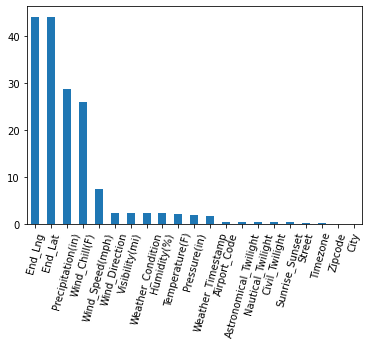

In [15]:
missing_percentage[missing_percentage != 0].plot(kind = "bar");
plt.xticks(rotation=75);
plt.show()

In [16]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year',
       'Hour', 'Month', 'Day', 'Time_of_Year', 'Duration',
       'Duration_in_minutes'],
      dtype='object')

## EDA and visualization

<AxesSubplot:xlabel='Severity', ylabel='count'>

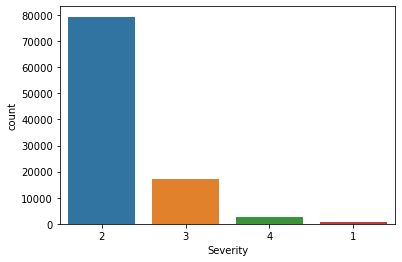

In [17]:
# Plotting the 'subscribed' frequency
sns.countplot(data=data, x='Severity')

In [18]:
crosstab=pd.crosstab(data["Timezone"],data["Severity"])
crosstab

Severity,1,2,3,4
Timezone,,,,
US/Central,153,16450,4411,416
US/Eastern,398,36337,7780,1684
US/Mountain,119,4370,825,224
US/Pacific,173,22134,4082,328


 #### Citywise Accidents in USA

In [19]:
cities = data.City.unique()
len(cities)

6433

In [20]:
#Showing no. of accidents in dfferent cities

cities_by_accidents = data.City.value_counts().sort_values(ascending = False)
cities_by_accidents

Miami          2405
Houston        2240
Los Angeles    1996
Charlotte      1776
Dallas         1686
               ... 
Mantoloking       1
Jellico           1
Wood Ridge        1
Freedom           1
Westwego          1
Name: City, Length: 6432, dtype: int64

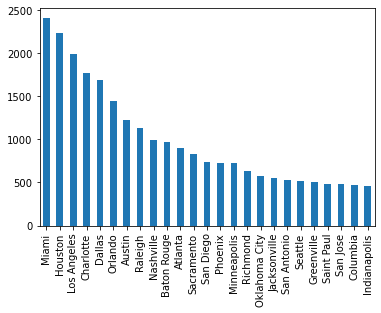

In [21]:
# Showing Top 25 cities with highest no. of accidents

cities_by_accidents[:25].plot(kind = 'bar');
plt.xticks(rotation=90)
plt.show()

In [22]:
high_accident_cities = cities_by_accidents[cities_by_accidents >=1000];
low_accident_cities = cities_by_accidents[cities_by_accidents < 1000];
print("No. of cities with high accidents are {}".format(len(high_accident_cities)))
print("Percentage of cities with high accidents are {}".format((len(high_accident_cities)/len(cities))*100))
print("No. of cities with low accidents are {}".format(len(low_accident_cities)))
print("Percentage of cities with low accidents are {}".format((len(low_accident_cities)/len(cities))*100))

No. of cities with high accidents are 8
Percentage of cities with high accidents are 0.1243587750660656
No. of cities with low accidents are 6424
Percentage of cities with low accidents are 99.86009637805068


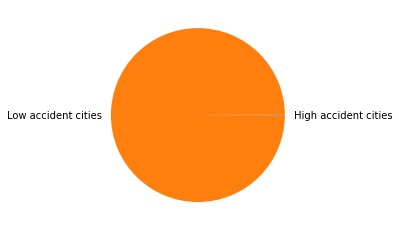

In [23]:
High_accident_zone = (len(high_accident_cities)/len(cities))*100
Low_accident_zone = (len(low_accident_cities)/len(cities))*100
y = np.array([High_accident_zone,Low_accident_zone])
mylabels = np.array(["High accident cities", "Low accident cities"])
plt.pie(y, labels = mylabels);
plt.show()

## Analysing by time

#### Weekly accident analysis

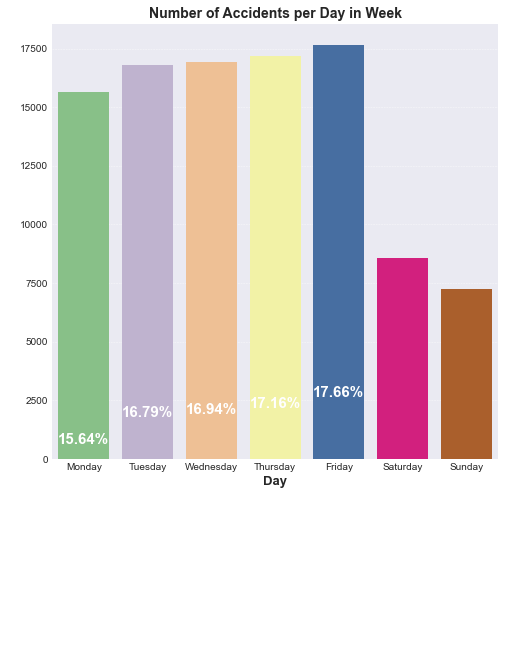

In [24]:
plt.style.use('seaborn-dark')

custom_palette = sns.color_palette("Accent", 7)

# Change the default color palette to the custom palette
sns.set_palette(custom_palette)

plt.figure(figsize=(8, 8))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x=data["Day"], order=order)

# Calculate the total counts
total_counts = data["Day"].value_counts()

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Day", fontsize=13, fontweight="bold")
plt.ylabel(" ")
plt.title("Number of Accidents per Day in Week", fontsize=14, fontweight="bold")

ax = plt.gca()

for i, bar in enumerate(ax.patches):
    proportion = (total_counts[order[i]]/total_counts.sum()) * 100
    ax.text(
        bar.get_x(),  
        bar.get_height()-15000,  
        f'{proportion:.2f}%',
        fontsize=15,
        weight='bold',
        color='white'
    )

plt.show()

In [25]:
data["Is_Weekend"] = data["Day"].isin(["Saturday", "Sunday"])

In [26]:
sns.reset_defaults()

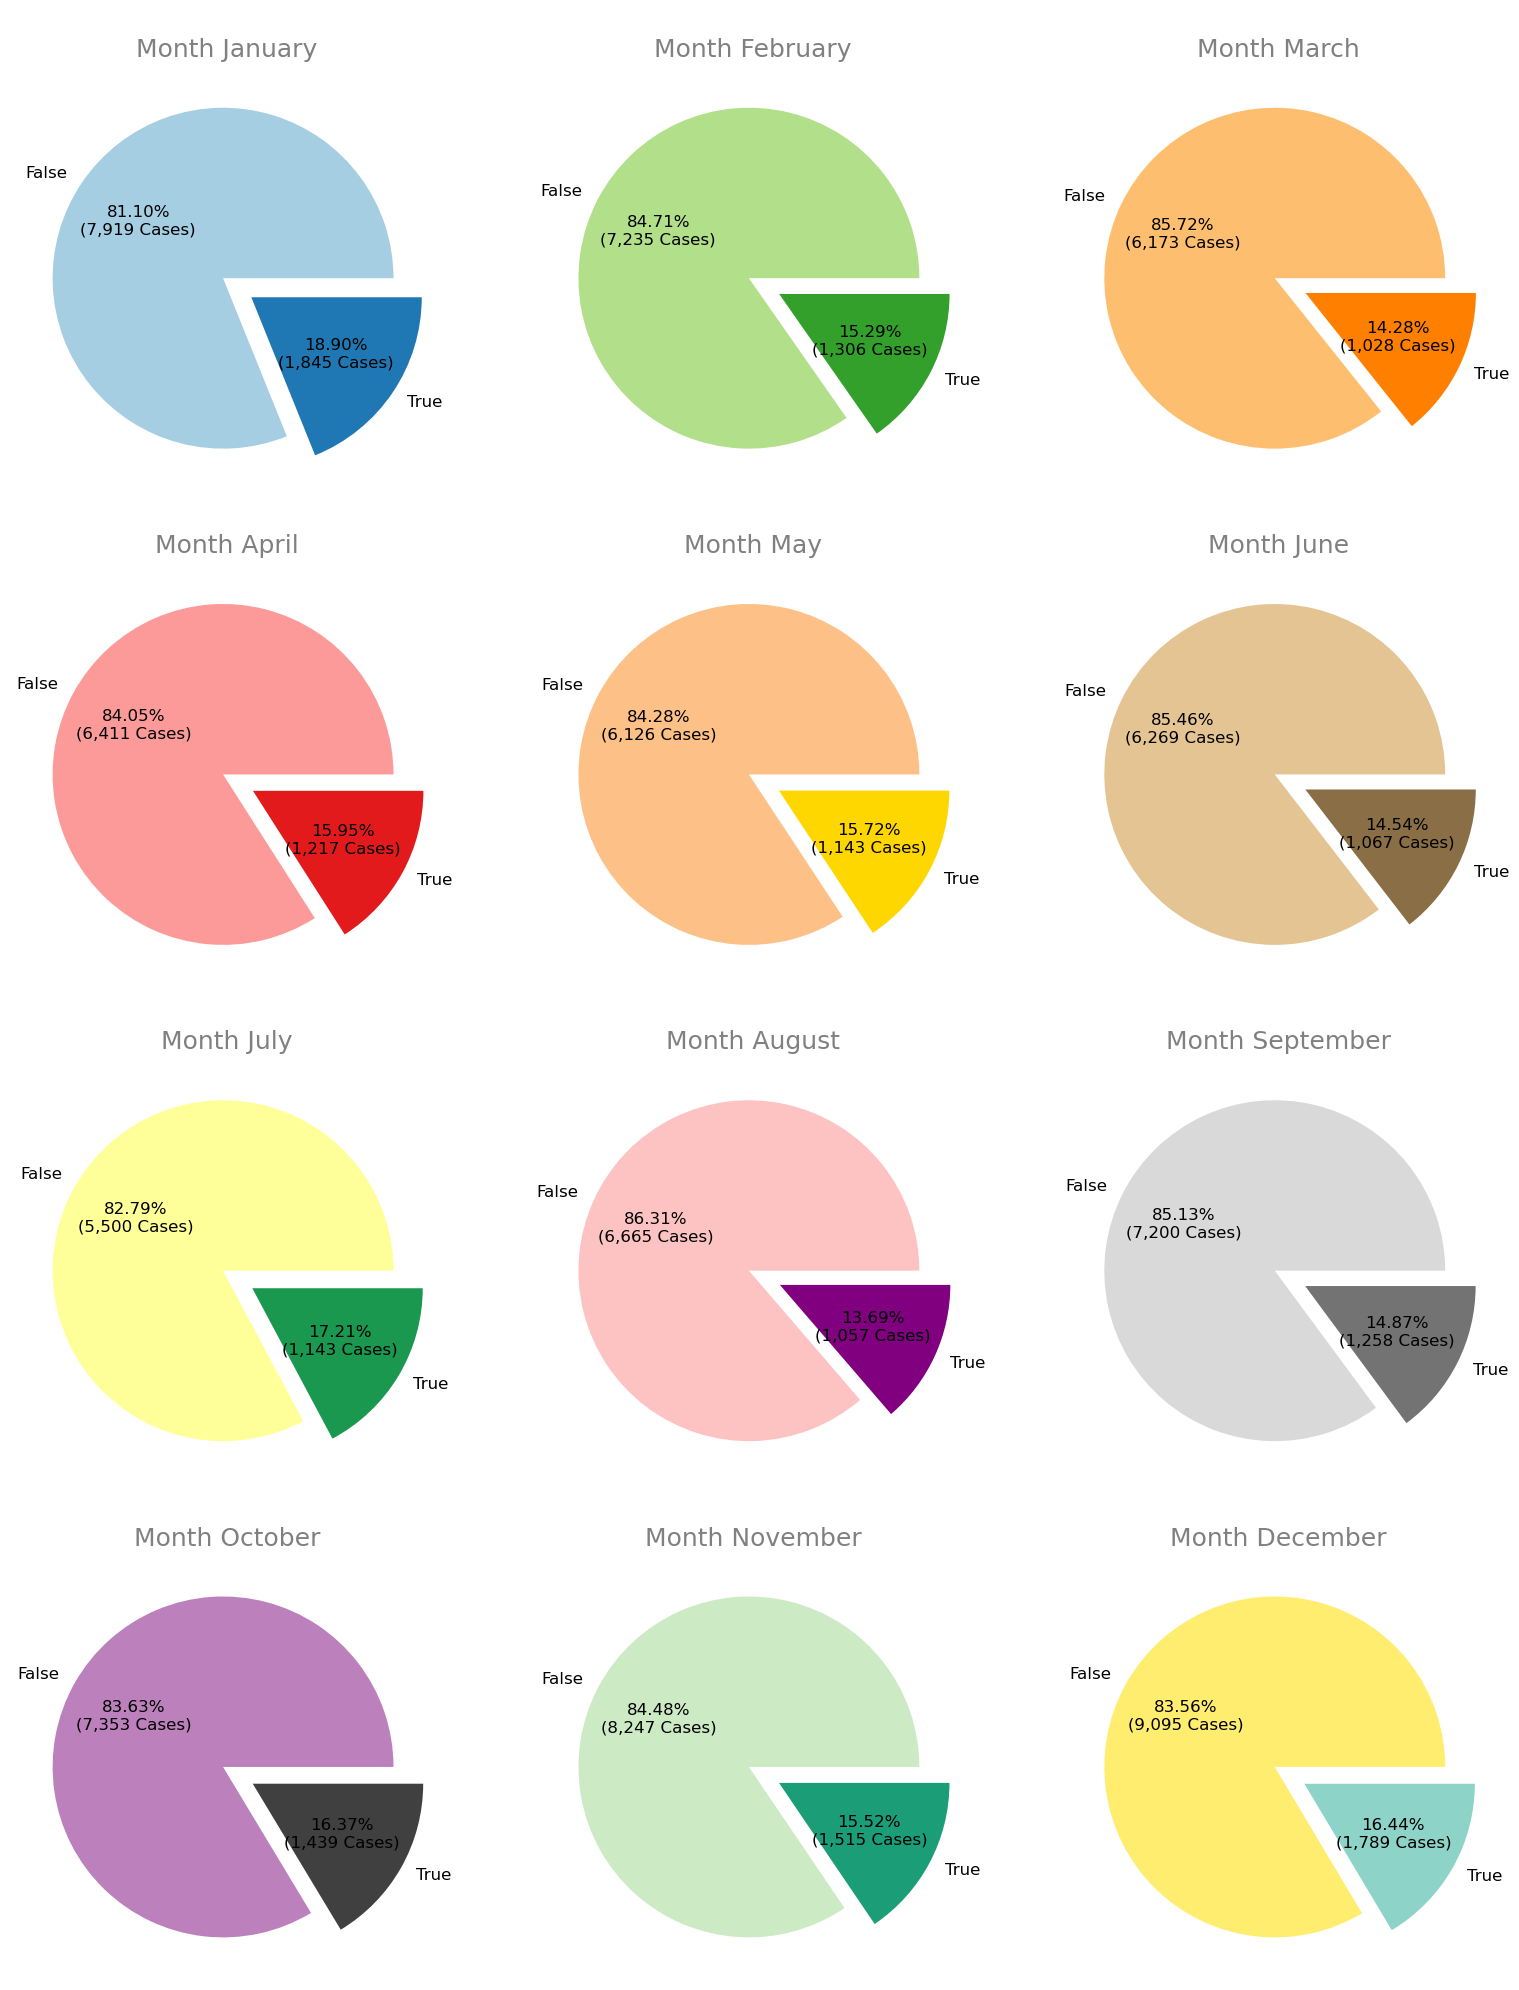

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

colors = [('#A6CEE3', '#1F78B4'), ('#B2DF8A', '#33A02C'), ('#FDBF6F', '#FF7F00'), ('#FB9A99', '#E31A1C'),
          ('#FDC086', '#FFD700'), ('#E5C494', '#8A6E45'), ('#FFFF99', '#1A9850'), ('#FDC3C3', '#800080'),
          ('#D9D9D9', '#737373'), ('#BC80BD', '#404040'), ('#CCEBC5', '#1B9E77'), ('#FFED6F', '#8DD3C7')]



count = 0

def func(pct, allvals):
    absolute = int(round(pct / 100 * np.sum(allvals), 2))
    return "{:.2f}%\n({:,d} Cases)".format(pct, absolute)

for i, ax in enumerate(axes.flatten()):
    month = i + 1
    size = list(data[data["Month"] == month]["Is_Weekend"].value_counts())
    if len(size) != 2:
        size.append(0)

    labels = ['False', 'True']

    ax.pie(size, labels=labels, colors=colors[count],
           autopct=lambda pct: func(pct, size), labeldistance=1.1,
           textprops={'fontsize': 12}, explode=[0, 0.2])

    title = '\n Month {}'.format(month_map[month])

    ax.set_title(title, fontsize=18, color='grey')

    count += 1
    
plt.tight_layout()
plt.show()

## Analysing by time

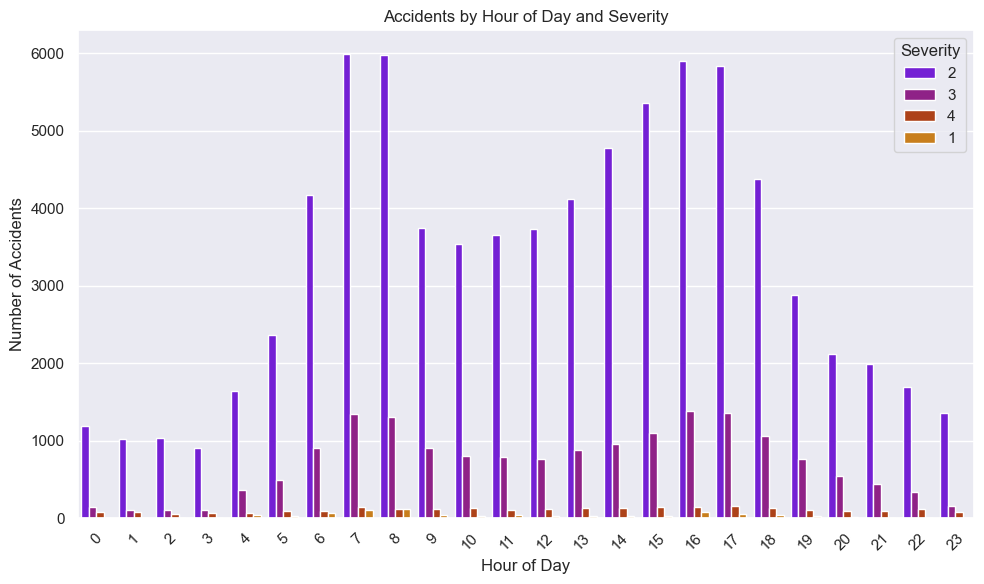

In [28]:
# Set chart style
palette=sns.color_palette('gnuplot')
sns.set(style="darkgrid", palette="gnuplot", context="notebook",)

# Extract hour of day from 'Start_Time'
data['Hour_of_Day'] = data['Start_Time'].dt.hour

# Create a new dataset with 'Severity' and 'Hour_of_Day' columns
severity_hour_dataset = data[['Severity', 'Hour_of_Day']].copy()

# Task 3: Create a Seaborn countplot to visualize accidents by hour and severity
plt.figure(figsize=(10, 6))
sns.countplot(data=severity_hour_dataset, x='Hour_of_Day', hue='Severity', palette='gnuplot')
plt.title('Accidents by Hour of Day and Severity')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

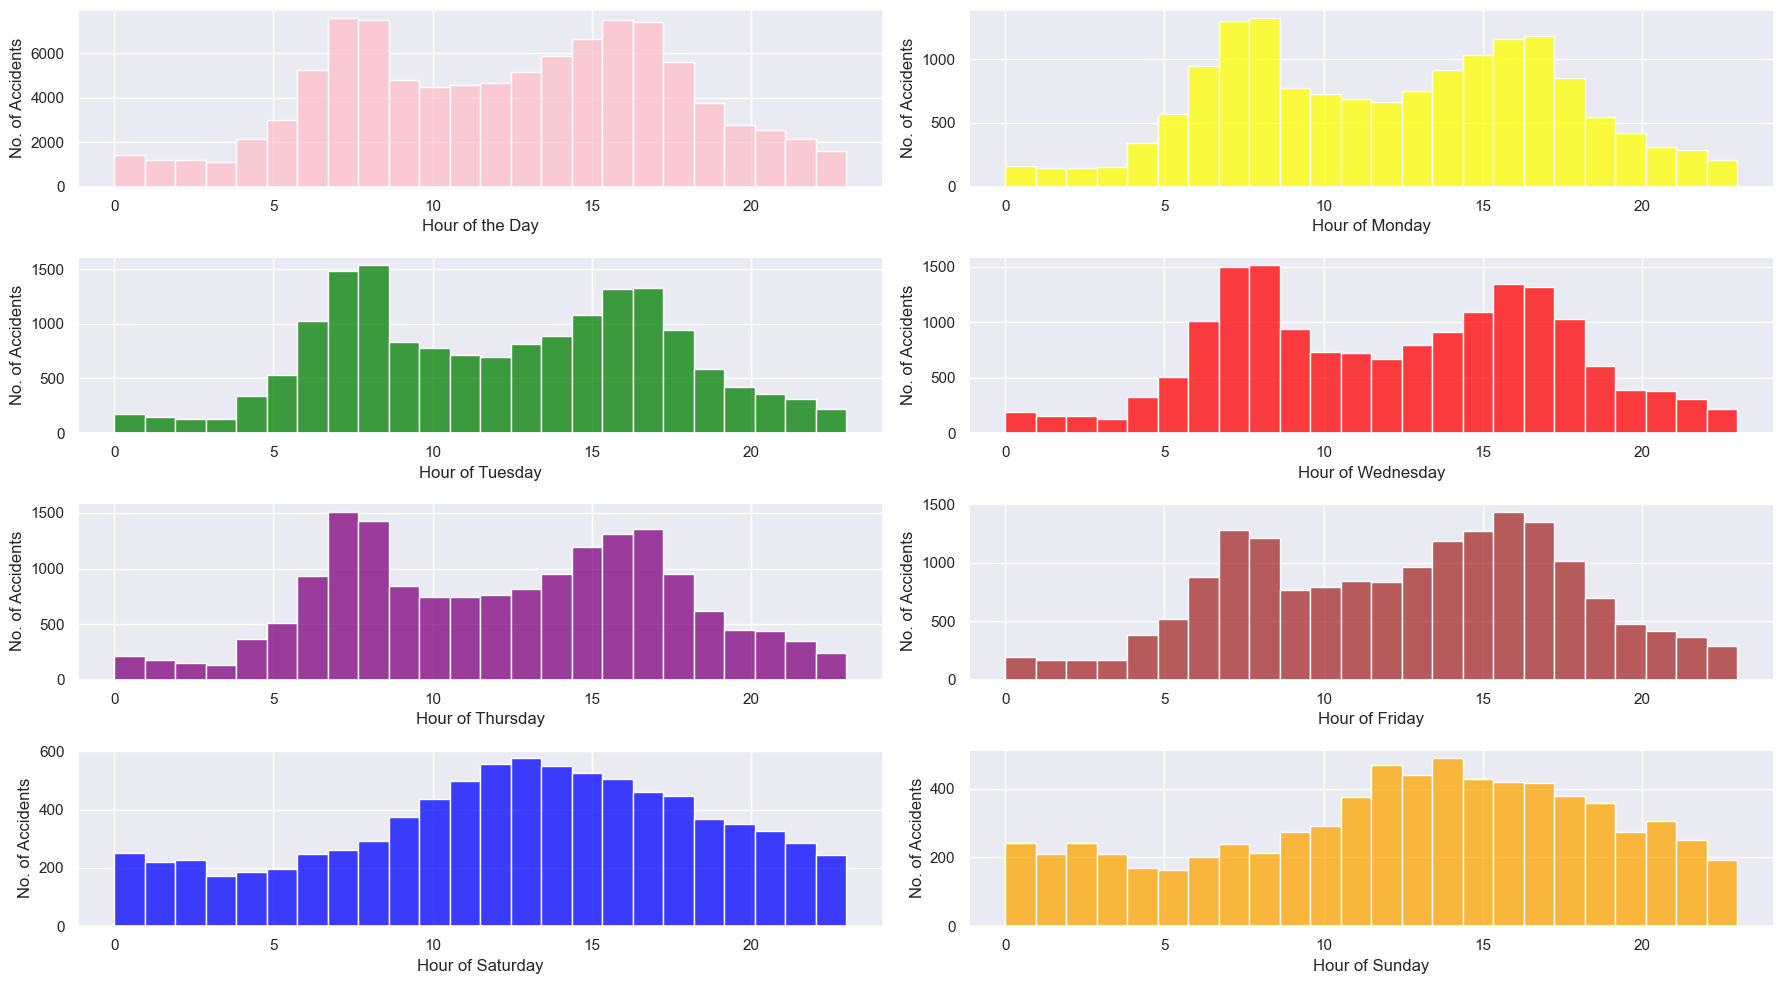

In [29]:
# Viewing the distribution of  hourly Accidents for each day of week separately.

fig,axes = plt.subplots(4, 2, figsize=(18, 10))

#For all days (Overall) Hourly accident distribution
sns.histplot(data.Start_Time.dt.hour, bins=24, ax=axes[0,0], color = "Pink");
axes[0,0].set_xlabel("Hour of the Day")
axes[0,0].set_ylabel("No. of Accidents")

#For Monday Hourly accident distribution

For_Monday = data.Start_Time[data.Start_Time.dt.dayofweek == 0]
Monday_distribution = sns.histplot(For_Monday.dt.hour, bins = 24, ax = axes[0,1], color = "Yellow")
axes[0,1].set_xlabel("Hour of Monday")
axes[0,1].set_ylabel("No. of Accidents")


#For Tuesday Hourly accident distribution

For_Tuesday = data.Start_Time[data.Start_Time.dt.dayofweek == 1]
Tuesday_distribution = sns.histplot(For_Tuesday.dt.hour, bins = 24, ax = axes[1,0],  color = "green")
axes[1,0].set_xlabel("Hour of Tuesday")
axes[1,0].set_ylabel("No. of Accidents")

#For Wednesday Hourly accident distribution

For_Wednesday = data.Start_Time[data.Start_Time.dt.dayofweek == 2]
Wednesday_distribution = sns.histplot(For_Wednesday.dt.hour, bins = 24, ax = axes[1,1],  color = "Red")
axes[1,1].set_xlabel("Hour of Wednesday")
axes[1,1].set_ylabel("No. of Accidents")

#For Thursday Hourly accident distribution

For_Thursday = data.Start_Time[data.Start_Time.dt.dayofweek == 3]
Thursday_distribution = sns.histplot(For_Thursday.dt.hour, bins = 24, ax = axes[2,0],  color = "Purple")
axes[2,0].set_xlabel("Hour of Thursday")
axes[2,0].set_ylabel("No. of Accidents")

#For Friday Hourly accident distribution

For_Friday = data.Start_Time[data.Start_Time.dt.dayofweek == 4]
Friday_distribution = sns.histplot(For_Friday.dt.hour, bins = 24, ax = axes[2,1],  color = "Brown")
axes[2,1].set_xlabel("Hour of Friday")
axes[2,1].set_ylabel("No. of Accidents")

#For Saturday Hourly accident distribution

For_saturday = data.Start_Time[data.Start_Time.dt.dayofweek == 5]
Saturday_distribution = sns.histplot(For_saturday.dt.hour, bins = 24, ax = axes[3,0],  color = "Blue")
axes[3,0].set_xlabel("Hour of Saturday")
axes[3,0].set_ylabel("No. of Accidents")

#For Sunday Hourly accident distribution

For_Sunday = data.Start_Time[data.Start_Time.dt.dayofweek == 6]
Sunday_distribution = sns.histplot(For_Sunday.dt.hour, bins = 24, ax = axes[3,1], color = "Orange")
axes[3,1].set_xlabel("Hour of Sunday")
axes[3,1].set_ylabel("No. of Accidents")


plt.tight_layout()
plt.show()

###  Analysing weather condition

In [30]:
len(data["Weather_Condition"].unique())

84

In [31]:
data["Weather_Condition"].value_counts()

Fair                    32895
Mostly Cloudy           13185
Cloudy                  10546
Clear                   10360
Partly Cloudy            9110
                        ...  
Heavy Sleet                 1
Thunder / Wintry Mix        1
Funnel Cloud                1
Light Rain Shower           1
Snow and Thunder            1
Name: Weather_Condition, Length: 83, dtype: int64

In [32]:
#Selecting only top 15 weather conditions which accounted for maximum accidents
weather = data['Weather_Condition'].value_counts().sort_values(ascending = False).head(15)     
weather

Fair                32895
Mostly Cloudy       13185
Cloudy              10546
Clear               10360
Partly Cloudy        9110
Overcast             4998
Light Rain           4595
Scattered Clouds     2726
Light Snow           1641
Fog                  1309
Rain                 1125
Haze                  983
Fair / Windy          470
Heavy Rain            439
Light Drizzle         283
Name: Weather_Condition, dtype: int64

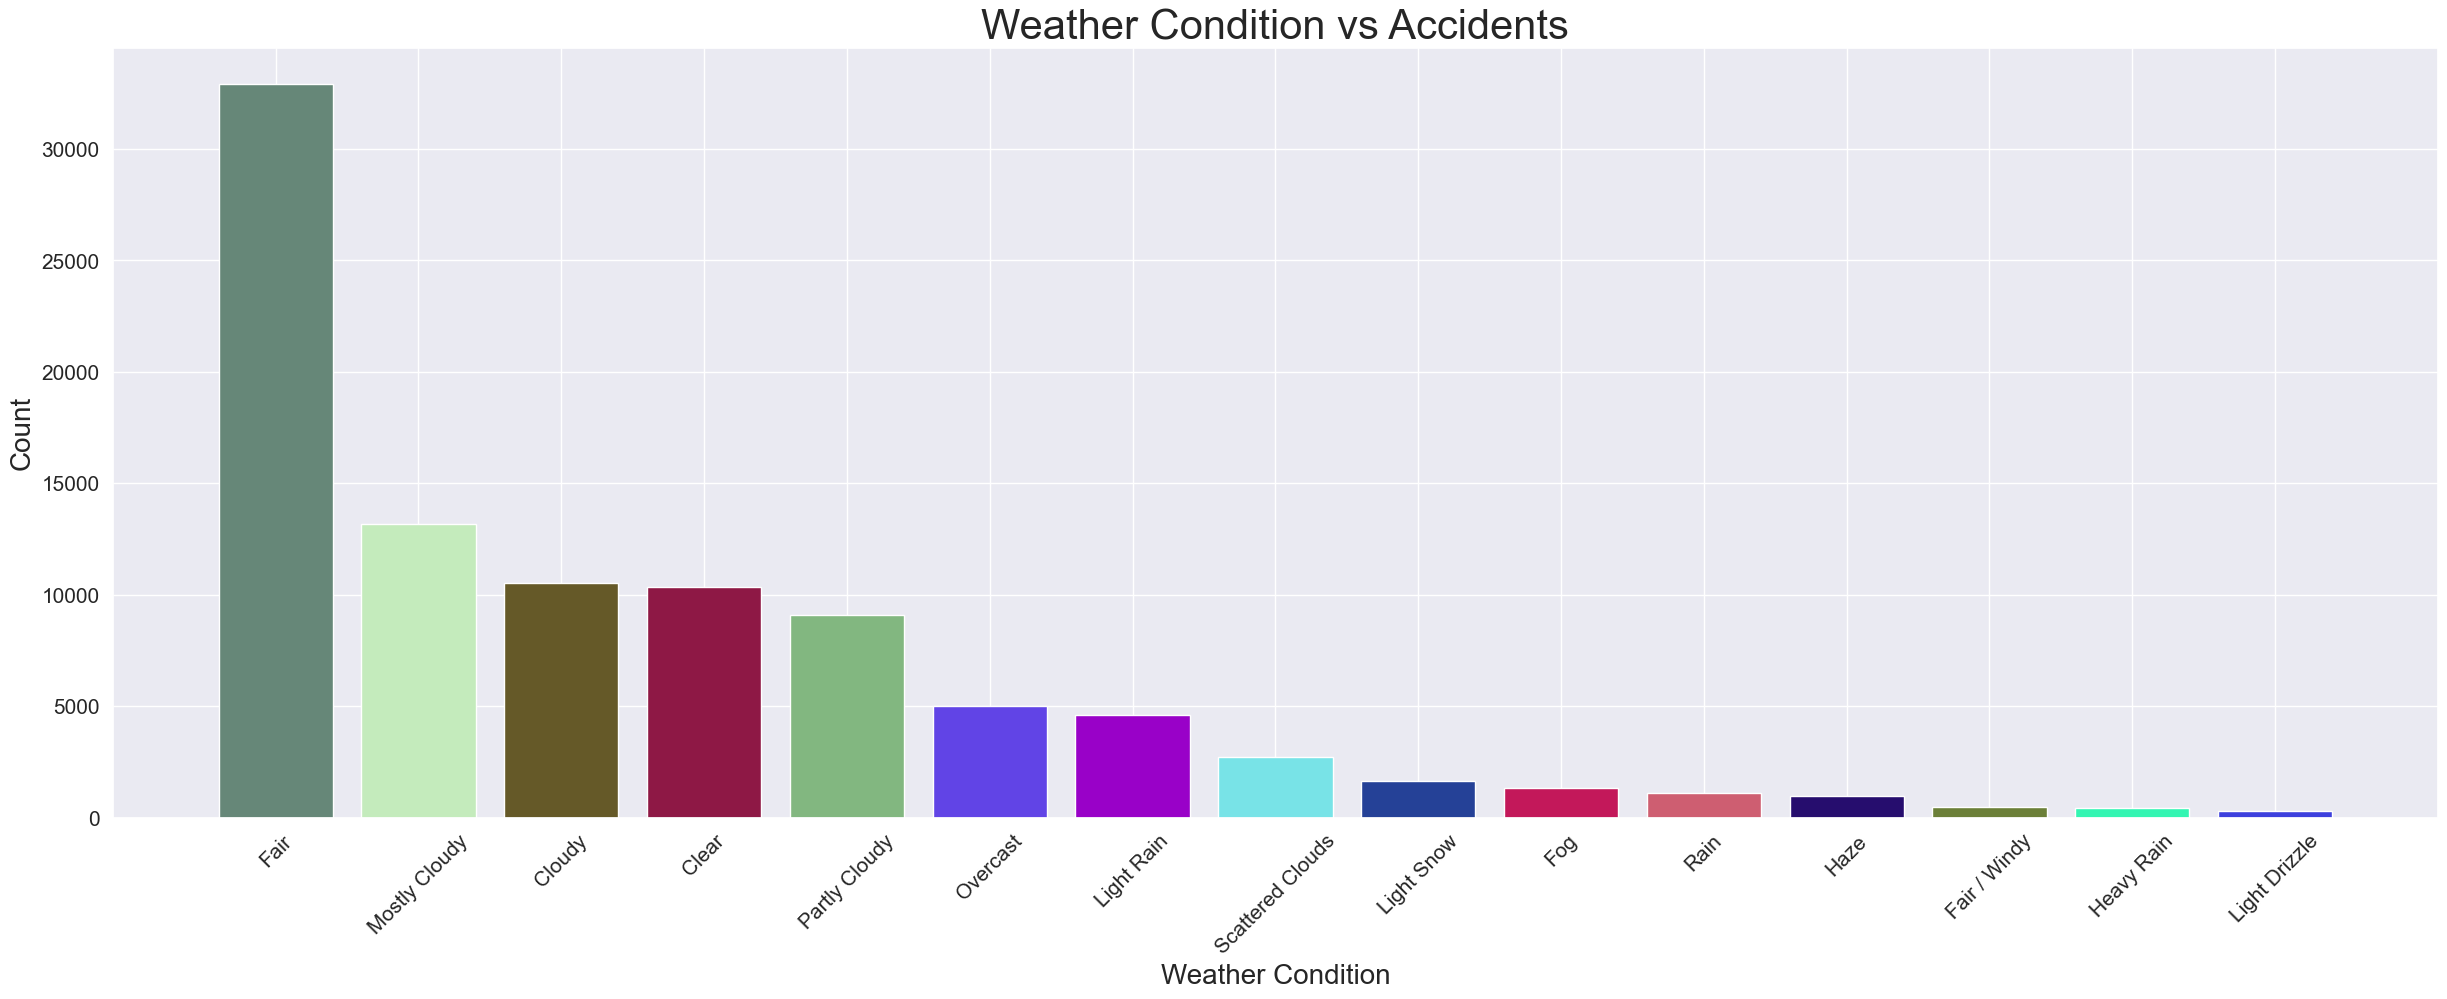

In [33]:
import random
figsize = (30, 10) 

Accident_Counts = weather.values
Weather_Conditions = weather.index
def generate_random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

bar_colors = [generate_random_color() for _ in range(len(Weather_Conditions))]

plt.figure(figsize=figsize)

plt.bar(Weather_Conditions, Accident_Counts, color=bar_colors)
plt.xticks(rotation=45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Weather Condition", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Weather Condition vs Accidents", fontsize = 30)

plt.show()

## Analysing by road

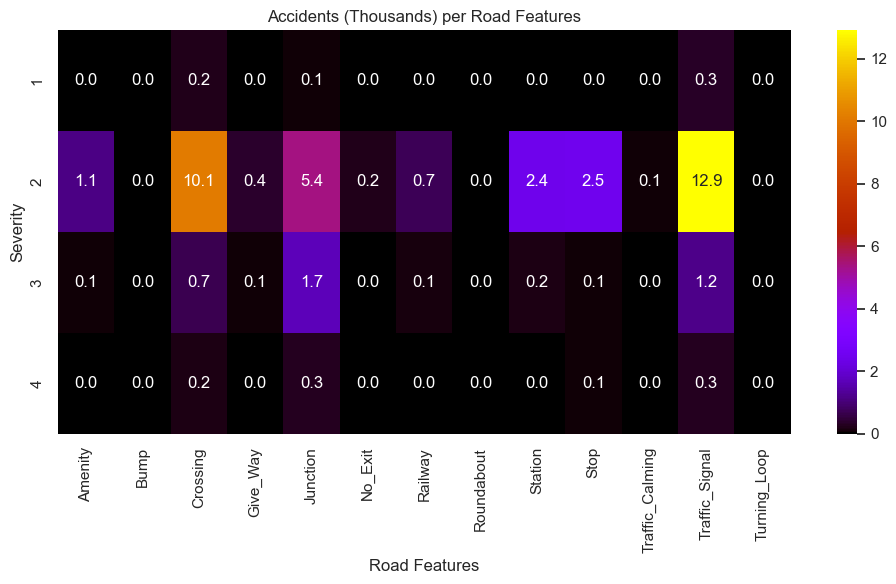

In [34]:
# Create a new dataset with boolean columns and severity
bool_severity_dataset = data[['Severity', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
                              'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
                              'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']].copy()

# Calculate the number of accidents for each combination of severity and boolean columns
accidents_by_bool_severity = bool_severity_dataset.groupby(['Severity']).sum()

# Create a heatmap to visualize the relationship between accident severity and boolean columns
plt.figure(figsize=(10, 6))
sns.heatmap(data=accidents_by_bool_severity/1000, cmap='gnuplot', annot=True, fmt='.1f')
plt.title('Accidents (Thousands) per Road Features')
plt.xlabel('Road Features')
plt.ylabel('Severity')
plt.tight_layout()

plt.show()

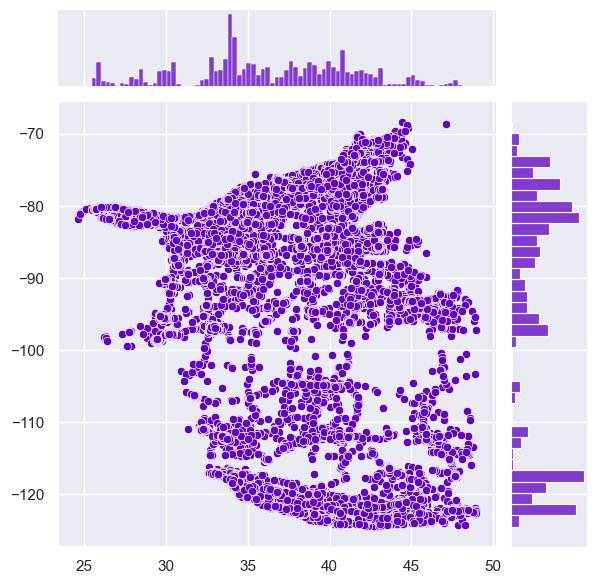

In [35]:
#. Longitude and Latitude with Accidents Density
data_num=data.select_dtypes(np.number)
sns.jointplot(x=data_num.Start_Lat.values , y=data_num.Start_Lng.values,height=6)
plt.ylabel('Start lattitude', fontsize=12)
plt.xlabel('Start lattitude', fontsize=12)
plt.show()

In [36]:
print(data.columns)

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year',
       'Hour', 'Month', 'Day', 'Time_of_Year', 'Duration',
       'Duration_in_minutes', 'Is_Weekend', 'Hour_of_Day'],
      dtype='object')


In [42]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Severity' column
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Step 3: Fit the model
xgb_model = XGBClassifier(objective='multi:softmax', 
                          num_class=4, 
                          random_state=42,  # Enable GPU acceleration
                         )

# Step 4: Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train_encoded)

# Step 5: Make predictions
predictions = pipeline.predict(X_val)


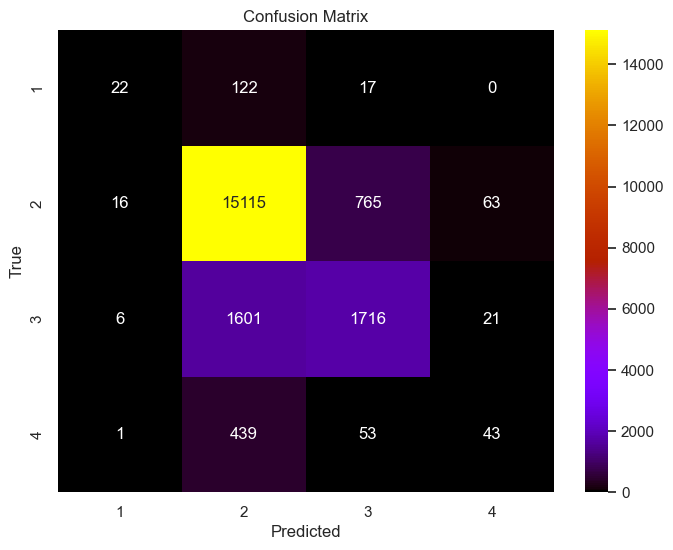

              precision    recall  f1-score   support

           1       0.49      0.14      0.21       161
           2       0.87      0.95      0.91     15959
           3       0.67      0.51      0.58      3344
           4       0.34      0.08      0.13       536

    accuracy                           0.84     20000
   macro avg       0.59      0.42      0.46     20000
weighted avg       0.82      0.84      0.83     20000



In [45]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_val_encoded, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='gnuplot', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_val_encoded, predictions, target_names=['1', '2', '3', '4'])
print(class_report)


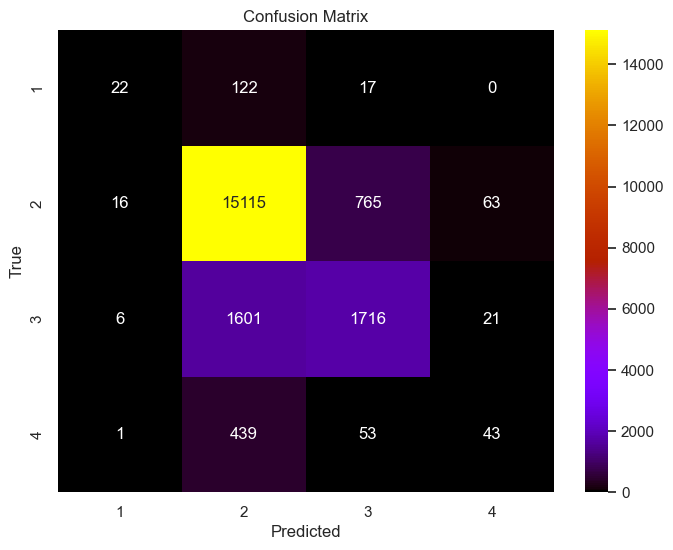

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       161
           1       0.85      0.97      0.91     15959
           2       0.71      0.39      0.50      3344
           3       0.16      0.01      0.01       536

    accuracy                           0.84     20000
   macro avg       0.68      0.35      0.36     20000
weighted avg       0.81      0.84      0.81     20000



In [50]:
# Set new hyperparameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,  # Number of classes
    'eval_metric': 'mlogloss',  # Evaluation metric
    'eta': 0.01,  # Lower learning rate to encourage exploration
    'max_depth': 8,  # Deeper trees for more complex interactions
    'min_child_weight': 2,  # Increase minimum child weight for regularization
    'subsample': 0.7,  # Slightly decrease subsample ratio
    'colsample_bytree': 0.7,  # Slightly decrease column subsample ratio
    'gamma': 0.5,  # Increase minimum loss reduction for partitions
    'reg_alpha': 0.3,  # Regularization for L1
    'reg_lambda': 0.8,  # Keep L2 regularization moderate
}

# Create the XGBoost model
new_model = XGBClassifier(**params)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', new_model)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train_encoded)

# Make predictions on the validation set
new_predictions = pipeline.predict(X_val)

# Compute confusion matrix
conf_mat = confusion_matrix(y_val_encoded, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='gnuplot', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the pipeline
print(classification_report(y_val_encoded, new_predictions))

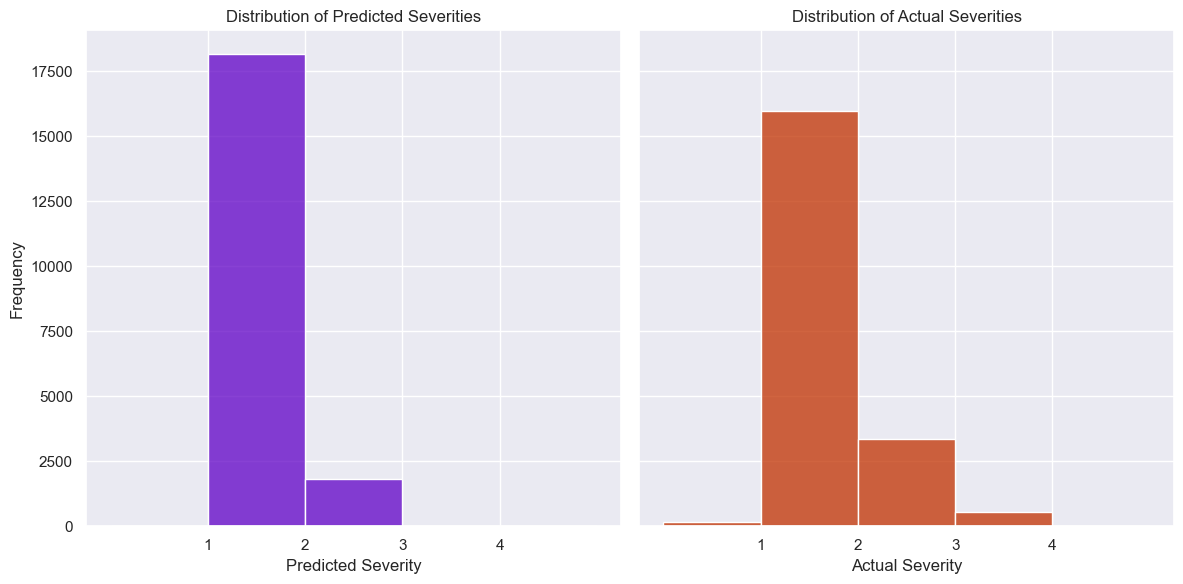

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the predicted distribution
sns.histplot(new_predictions, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[0], ax=axes[0])
axes[0].set_xlabel('Predicted Severity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Severities')
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xticklabels(['1', '2', '3', '4'])

# Plot the actual distribution
sns.histplot(y_val_encoded, bins=[0, 1, 2, 3, 4, 5], kde=False, color=palette[3], ax=axes[1])
axes[1].set_xlabel('Actual Severity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Actual Severities')
axes[1].set_xticks([1, 2, 3, 4])
axes[1].set_xticklabels(['1', '2', '3', '4'])

plt.tight_layout()
plt.show()

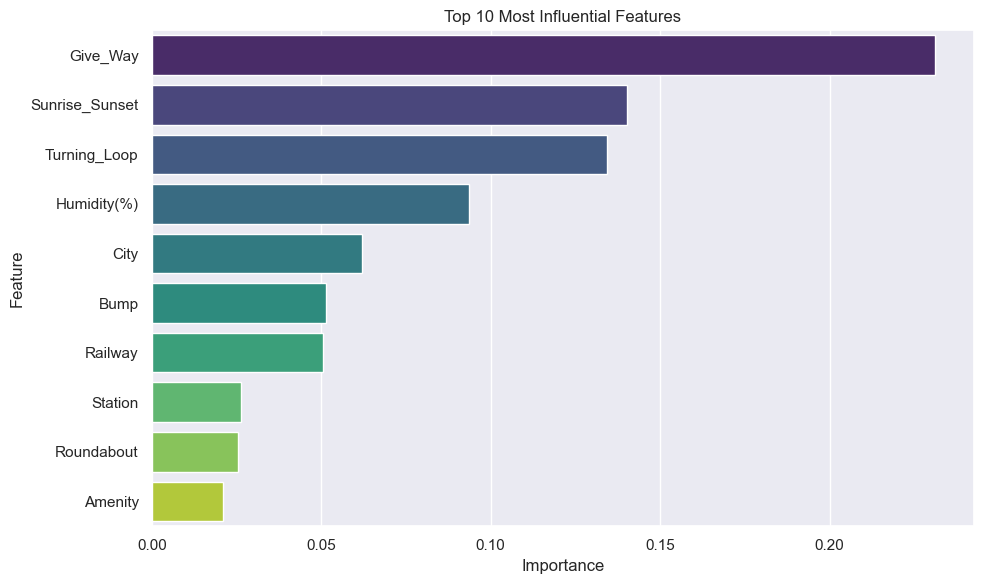

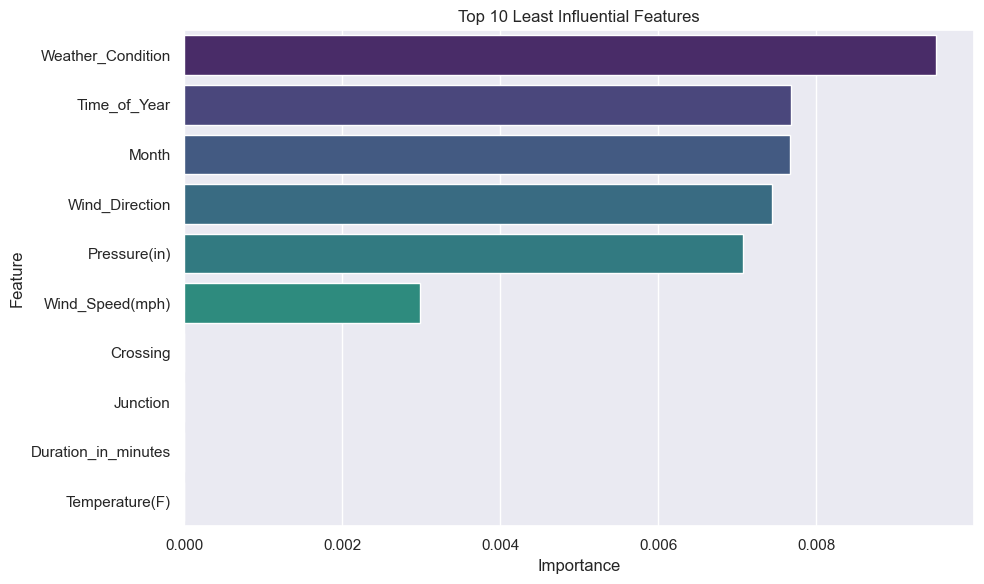

In [52]:
# Get feature importances from the XGBoost model inside the pipeline
feature_importances = pipeline.named_steps['model'].feature_importances_

# Get the column names from the preprocessor
categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
    .named_steps['encoder'].get_feature_names_out()

all_feature_names = np.concatenate([categories, numeric_cols])

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Generate elegant Seaborn bar charts for most and least influential features
plt.figure(figsize=(10, 6))

# Most influential features
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Most Influential Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Least influential features
sns.barplot(data=importance_df.tail(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Least Influential Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()